In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# global variables
train_losses_without_L1_L2 = []
test_losses_without_L1_L2 = []
train_acc_without_L1_L2 = []
test_acc_without_L1_L2 = []
misclassified_without_L1_L2_list = {}

train_losses_L1 = []
train_acc_L1 = []
test_losses_L1 = []
test_acc_L1 = []
misclassified_L1_list = {}

train_losses_L2 = []
train_acc_L2 = []
test_losses_L2 = []
test_acc_L2 = []
misclassified_L2_list = {}

train_losses_L1_L2 = []
train_acc_L1_L2 = []
test_losses_L1_L2 = []
test_acc_L1_L2 = []
misclassified_L1_L2_list = {}
use_cuda = torch.cuda.is_available()
# train_loader='0'
# test_loader='0'
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
def transformations():
  # Train Phase transformations
  train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

  # Test Phase transformations
  test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
  return train_transforms , test_transforms

In [0]:
def train_test_dataloaders(seed, batch_size, workers):
  train_transforms, test_transforms = transformations()
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  SEED = seed

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
  return train_loader, test_loader

In [0]:
# dropout_value = 0.1
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout(dropout_value)
        ) # output_size = 26

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)            
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)            
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)            
        ) # output_size = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout(dropout_value)            
        ) # output_size = 7

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(dropout_value)            
        ) # output_size = 5
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 3
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
def model_params(model, input_size):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)
  model = model.to(device)
  #summary(model, input_size=(1, 28, 28))
  summary(model, input_size)

In [0]:
def compute_L1_Loss(model, data, factor=0.0005):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def train(model, device, train_loader, optimizer, epoch, isL1, train_acc, train_losses):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if isL1:
      loss += compute_L1_Loss(model,data,factor=0.0005)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [0]:
def test(model, device, test_loader, test_acc, test_losses, misclassified_list):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            i=len(misclassified_list)
            orig_data=data.numpy()
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            for x,y,z in zip(pred,new_target,orig_data):
              if x!=y:
                # print("type= {} {} ".format(x,y))
                # print("Z", z.shape)
                misclassified_list[i]=[x,y,z]
                i +=1
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

In [0]:
def plotall():
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses_without_L1_L2, label='without L1 and L2')
  axs[0].plot(test_losses_L1, label='with L1 only')
  axs[0].plot(test_losses_L2, label='with L2 only')
  axs[0].plot(test_losses_L1_L2, label='with L1 and L2 both')
  axs[0].set_title("Test Loss")
  axs[0].legend()
  axs[1].plot(test_acc_without_L1_L2, label='without L1 and L2')
  axs[1].plot(test_acc_L1, label='with L1 only')
  axs[1].plot(test_acc_L2, label='with L2 only')
  axs[1].plot(test_acc_L1_L2, label='with L1 and L2 both')
  axs[1].set_title("Test Accuracy")
  axs[1].legend()
  plt.savefig('/content/gdrive/My Drive/plot.png')

In [0]:
def plot_misclassified_images(missclassified,filename):
  mis_Class_list=list(missclassified.values())
  # each_Item=missclassified.keys()
  # print("type= ",(mis_Class_list[1][2]))
  print("classified= ",mis_Class_list[0][2].shape)
  print("classified1= ",mis_Class_list[0][2].reshape(28,28,1).shape)
  fig = plt.figure(figsize=(10, 10))  # width, height in inches
  columns = 5
  rows = 5
  for i in range(columns*rows):
      sub = fig.add_subplot(rows, columns, i+1)
      each_img=mis_Class_list[i][2]
      shape_change=each_img.reshape(28,28)
      # print("new shape= ",shape_change.shape)
      # sub.imshow(plt.imshow(shape_change,cmap='gray',interpolation='none'))
      plt.imshow(shape_change,cmap='gray',interpolation='none')
      sub.set_title("Pred={}, Act={}".format(mis_Class_list[i][0].tolist()[0],mis_Class_list[i][1].tolist()[0]))
  plt.tight_layout()
  plt.savefig(os.path.join('/content/gdrive/My Drive',filename))
  plt.show()

In [0]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [0]:
def invoke_process_without_L1_and_L2():
  train_transforms, test_transforms = transformations()
  train_loader, test_loader = train_test_dataloaders(1, 64, 4)
  model =  Net(1.0).to(device)
  model_params(model, (1, 28, 28))  
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False, train_acc_without_L1_L2, train_losses_without_L1_L2)
      test(model, device, test_loader, test_acc_without_L1_L2, test_losses_without_L1_L2, misclassified_without_L1_L2_list)
  plot(train_losses_without_L1_L2,train_acc_without_L1_L2, test_losses_without_L1_L2, test_acc_without_L1_L2, 'without L1 and L2')
  save_model(model, '/content/gdrive/My Drive/Assign-6-without-L1AndL2.pth')
  print("miss",len(misclassified_without_L1_L2_list))
  # plot_misclassified_images(misclassified_without_L1_L2_list)

In [0]:
def invoke_process_with_L1():
  train_transforms, test_transforms = transformations()
  train_loader, test_loader = train_test_dataloaders(1, 64, 4)
  model =  Net(1.0).to(device)
  model_params(model, (1, 28, 28))  
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True, train_acc_L1, train_losses_L1)
      test(model, device, test_loader, test_acc_L1, test_losses_L1, misclassified_L1_list )
  plot(train_losses_L1,train_acc_L1, test_losses_L1, test_acc_L1, 'with L1 only')
  save_model(model, '/content/gdrive/My Drive/Assign-6-with-L1.pth')
  plot_misclassified_images(misclassified_L1_list,"misclassified_L1_list.png")

In [0]:
def invoke_process_with_L2():
  train_transforms, test_transforms = transformations()
  train_loader, test_loader = train_test_dataloaders(1, 64, 4)
  model =  Net(1.0).to(device)
  model_params(model, (1, 28, 28))  
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, False, train_acc_L2, train_losses_L2)
      test(model, device, test_loader, test_acc_L2, test_losses_L2, misclassified_L2_list)
  plot(train_losses_L2,train_acc_L2, test_losses_L2, test_acc_L2, 'with L2 only')
  save_model(model, '/content/gdrive/My Drive/Assign-6-with-L2.pth')
  plot_misclassified_images(misclassified_L2_list,"misclassified_L2_list.png")

In [0]:
def invoke_process_with_L1_and_L2():
  train_transforms, test_transforms = transformations()
  train_loader, test_loader = train_test_dataloaders(1, 64, 4)
  model =  Net(1.0).to(device)
  model_params(model, (1, 28, 28))  
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch, True, train_acc_L1_L2, train_losses_L1_L2)
      test(model, device, test_loader, test_acc_L1_L2, test_losses_L1_L2, misclassified_L1_L2_list)
  plot(train_losses_L1_L2,train_acc_L1_L2, test_losses_L1_L2, test_acc_L1_L2,'with L1 and L2 both')
  save_model(model, '/content/gdrive/My Drive/Assign-6-with-L1AndL2.pth')


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
CUDA Available? True


  0%|          | 0/938 [00:00<?, ?it/s]

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Conv2d-14              

Loss=0.021253734827041626 Batch_id=937 Accuracy=92.27: 100%|██████████| 938/938 [00:19<00:00, 48.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.03481832146644592 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:20<00:00, 46.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.22929196059703827 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:19<00:00, 47.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

EPOCH: 3


Loss=0.17517893016338348 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:19<00:00, 47.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.01913917064666748 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9925/10000 (99.25%)

EPOCH: 5


Loss=0.00935836136341095 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:19<00:00, 48.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.02973558008670807 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:19<00:00, 47.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.05810999870300293 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:19<00:00, 47.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.009159505367279053 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:19<00:00, 57.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.007821455597877502 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:19<00:00, 48.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.03875413537025452 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:19<00:00, 48.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.006035476922988892 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:19<00:00, 47.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.0030483901500701904 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:19<00:00, 48.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.05527900159358978 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:18<00:00, 49.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.006912693381309509 Batch_id=937 Accuracy=99.04: 100%|██████████| 938/938 [00:18<00:00, 49.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.1008271723985672 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:18<00:00, 50.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.004700720310211182 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.049398958683013916 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [00:19<00:00, 48.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.004884511232376099 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 48.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.08501425385475159 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.019779831171035767 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:19<00:00, 48.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 21


Loss=0.006896898150444031 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:19<00:00, 48.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.04565860331058502 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:19<00:00, 49.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9927/10000 (99.27%)

EPOCH: 23


Loss=0.006070777773857117 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:19<00:00, 48.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.0051422119140625 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:19<00:00, 49.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.08423729240894318 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:19<00:00, 48.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.008815944194793701 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9925/10000 (99.25%)

EPOCH: 27


Loss=0.009616181254386902 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:18<00:00, 50.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 28


Loss=0.01124371588230133 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:19<00:00, 48.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.011284619569778442 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:19<00:00, 48.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.009741723537445068 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:18<00:00, 51.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9936/10000 (99.36%)

EPOCH: 31


Loss=0.007429435849189758 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:18<00:00, 49.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.375205397605896 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:18<00:00, 50.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.013411343097686768 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:18<00:00, 55.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.007967263460159302 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:19<00:00, 47.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.010877847671508789 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:19<00:00, 48.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.0976475402712822 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:19<00:00, 48.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.07182203233242035 Batch_id=937 Accuracy=99.35: 100%|██████████| 938/938 [00:19<00:00, 48.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 38


Loss=0.16709458827972412 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:19<00:00, 48.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9948/10000 (99.48%)

EPOCH: 39


Loss=0.02413007616996765 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]



Test set: Average loss: 0.0194, Accuracy: 9942/10000 (99.42%)

miss 2854


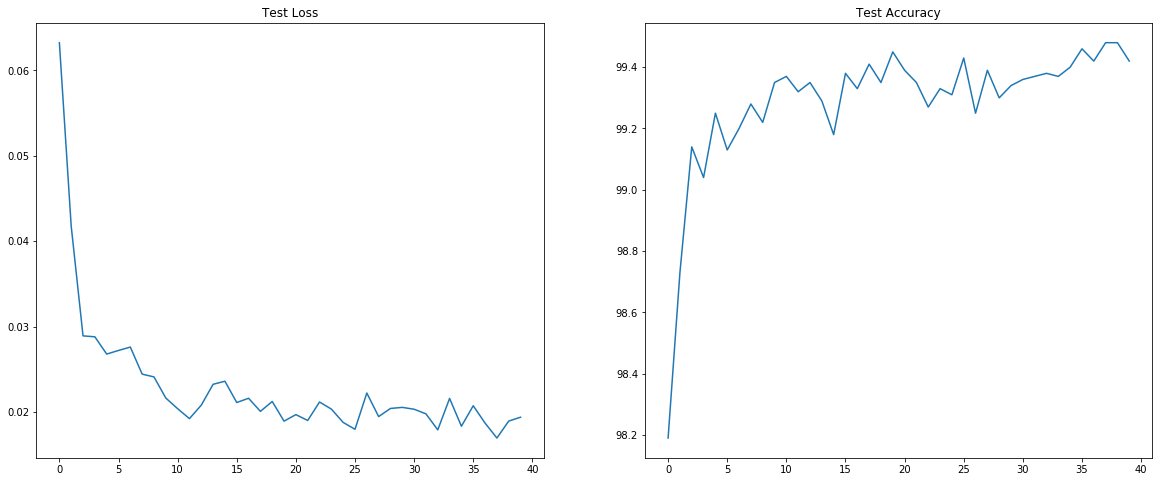

In [19]:
invoke_process_without_L1_and_L2()

  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Co

Loss=0.019032057374715805 Batch_id=937 Accuracy=92.40: 100%|██████████| 938/938 [00:23<00:00, 39.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9808/10000 (98.08%)

EPOCH: 1


Loss=0.04352715611457825 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:23<00:00, 39.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9888/10000 (98.88%)

EPOCH: 2


Loss=0.27530431747436523 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:23<00:00, 39.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9914/10000 (99.14%)

EPOCH: 3


Loss=0.2121375948190689 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [00:24<00:00, 38.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.09601227939128876 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:23<00:00, 39.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.01096591167151928 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:23<00:00, 40.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 6


Loss=0.053557541221380234 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:23<00:00, 39.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.060903895646333694 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:23<00:00, 40.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.02017228677868843 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:23<00:00, 39.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.009103527292609215 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:22<00:00, 40.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.045048825442790985 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:22<00:00, 41.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9939/10000 (99.39%)

EPOCH: 11


Loss=0.0181652270257473 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:22<00:00, 41.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.013934409245848656 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:22<00:00, 41.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.01843283697962761 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [00:22<00:00, 41.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.007663466967642307 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [00:22<00:00, 41.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.06486917287111282 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:22<00:00, 41.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.010613417252898216 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:23<00:00, 40.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.02521342970430851 Batch_id=937 Accuracy=99.09: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.007725952193140984 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:22<00:00, 40.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.044216088950634 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:22<00:00, 41.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.014079101383686066 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:22<00:00, 41.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.006419440731406212 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:22<00:00, 41.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9938/10000 (99.38%)

EPOCH: 22


Loss=0.016507403925061226 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:22<00:00, 41.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)

EPOCH: 23


Loss=0.010391198098659515 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:22<00:00, 46.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.01425386592745781 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:22<00:00, 41.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.053836390376091 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:22<00:00, 41.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9927/10000 (99.27%)

EPOCH: 26


Loss=0.008390307426452637 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:23<00:00, 40.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.03612031042575836 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:22<00:00, 41.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 28


Loss=0.02052922174334526 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:23<00:00, 48.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 29


Loss=0.00741885369643569 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:22<00:00, 41.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9933/10000 (99.33%)

EPOCH: 30


Loss=0.018471023067831993 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:23<00:00, 40.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.007893739268183708 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:22<00:00, 41.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


Loss=0.385334312915802 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:22<00:00, 41.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)

EPOCH: 33


Loss=0.008885888382792473 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:22<00:00, 41.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9950/10000 (99.50%)

EPOCH: 34


Loss=0.007532058283686638 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:22<00:00, 41.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)

EPOCH: 35


Loss=0.03235730156302452 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:23<00:00, 40.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.10920219123363495 Batch_id=937 Accuracy=99.38: 100%|██████████| 938/938 [00:22<00:00, 41.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9944/10000 (99.44%)

EPOCH: 37


Loss=0.061587464064359665 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:22<00:00, 47.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0167, Accuracy: 9952/10000 (99.52%)

EPOCH: 38


Loss=0.22579552233219147 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:22<00:00, 46.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.00867623183876276 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:22<00:00, 42.26it/s]



Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

classified=  (1, 28, 28)
classified1=  (28, 28, 1)


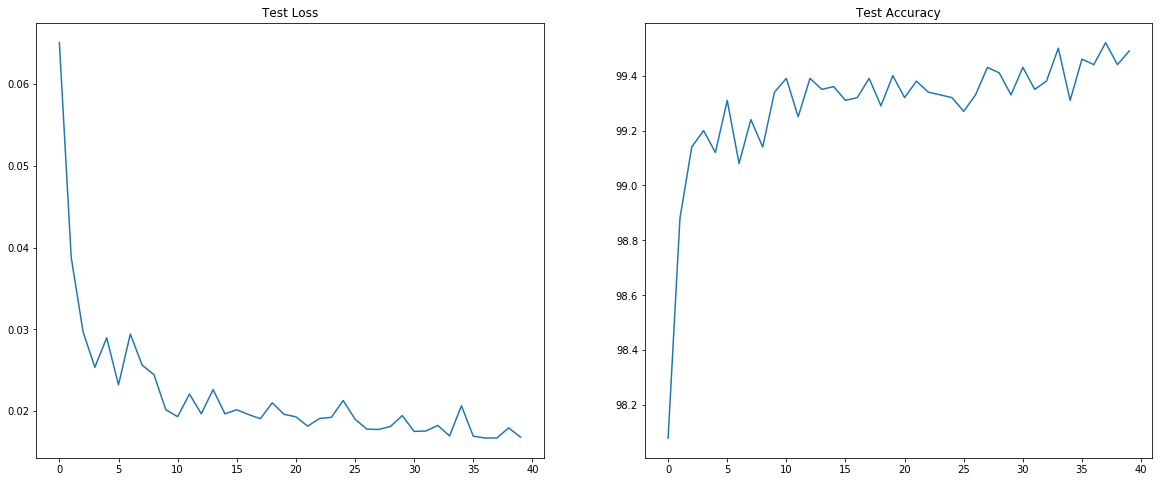

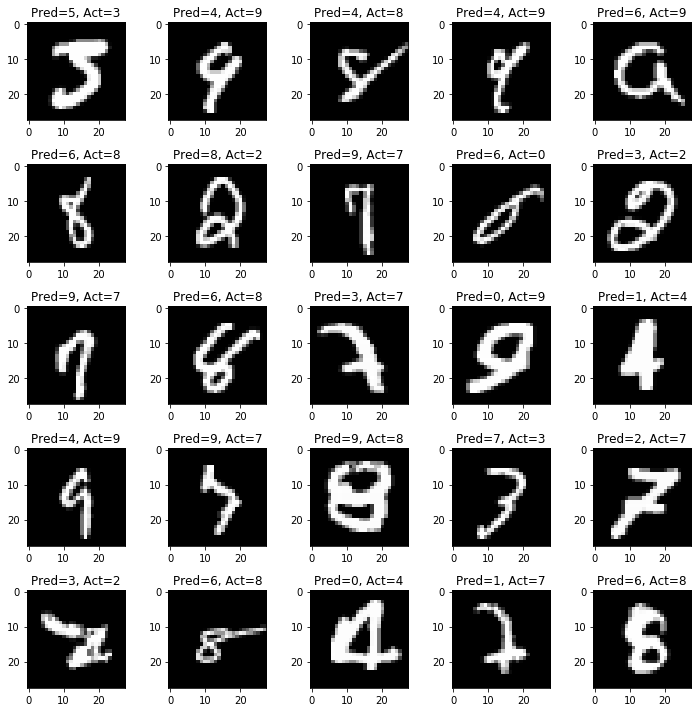

In [20]:
invoke_process_with_L1()

  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Co

Loss=0.04838985204696655 Batch_id=937 Accuracy=92.22: 100%|██████████| 938/938 [00:19<00:00, 49.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0977, Accuracy: 9756/10000 (97.56%)

EPOCH: 1


Loss=0.07764534652233124 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [00:18<00:00, 49.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.1939089447259903 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:19<00:00, 48.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.1549406796693802 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:19<00:00, 49.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9825/10000 (98.25%)

EPOCH: 4


Loss=0.037531569600105286 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:19<00:00, 56.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9874/10000 (98.74%)

EPOCH: 5


Loss=0.0819292664527893 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:19<00:00, 48.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9851/10000 (98.51%)

EPOCH: 6


Loss=0.14995059370994568 Batch_id=937 Accuracy=97.89: 100%|██████████| 938/938 [00:19<00:00, 49.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0878, Accuracy: 9803/10000 (98.03%)

EPOCH: 7


Loss=0.1840241402387619 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:18<00:00, 49.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0644, Accuracy: 9857/10000 (98.57%)

EPOCH: 8


Loss=0.07726449519395828 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:19<00:00, 48.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9861/10000 (98.61%)

EPOCH: 9


Loss=0.04993467777967453 Batch_id=937 Accuracy=97.94: 100%|██████████| 938/938 [00:19<00:00, 49.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9896/10000 (98.96%)

EPOCH: 10


Loss=0.0752534419298172 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:19<00:00, 48.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9831/10000 (98.31%)

EPOCH: 11


Loss=0.05011635273694992 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:19<00:00, 49.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.02838006615638733 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:18<00:00, 49.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0748, Accuracy: 9832/10000 (98.32%)

EPOCH: 13


Loss=0.06398474425077438 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:19<00:00, 48.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0721, Accuracy: 9820/10000 (98.20%)

EPOCH: 14


Loss=0.09093797206878662 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:18<00:00, 49.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9843/10000 (98.43%)

EPOCH: 15


Loss=0.2092999368906021 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:18<00:00, 49.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9857/10000 (98.57%)

EPOCH: 16


Loss=0.045628443360328674 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:19<00:00, 49.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9845/10000 (98.45%)

EPOCH: 17


Loss=0.08418409526348114 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:19<00:00, 49.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9893/10000 (98.93%)

EPOCH: 18


Loss=0.05074725300073624 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:18<00:00, 49.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 9860/10000 (98.60%)

EPOCH: 19


Loss=0.10807061940431595 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:19<00:00, 48.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9886/10000 (98.86%)

EPOCH: 20


Loss=0.0732121393084526 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:18<00:00, 49.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0771, Accuracy: 9824/10000 (98.24%)

EPOCH: 21


Loss=0.045301273465156555 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:18<00:00, 50.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9883/10000 (98.83%)

EPOCH: 22


Loss=0.13353729248046875 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:18<00:00, 49.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9871/10000 (98.71%)

EPOCH: 23


Loss=0.12810620665550232 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:18<00:00, 49.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0845, Accuracy: 9805/10000 (98.05%)

EPOCH: 24


Loss=0.0811801552772522 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:19<00:00, 49.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9831/10000 (98.31%)

EPOCH: 25


Loss=0.11255794018507004 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:18<00:00, 49.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9879/10000 (98.79%)

EPOCH: 26


Loss=0.10216231644153595 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:19<00:00, 48.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9888/10000 (98.88%)

EPOCH: 27


Loss=0.05233820527791977 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:19<00:00, 47.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9871/10000 (98.71%)

EPOCH: 28


Loss=0.05958700180053711 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:19<00:00, 47.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9869/10000 (98.69%)

EPOCH: 29


Loss=0.05123776197433472 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:19<00:00, 47.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9785/10000 (97.85%)

EPOCH: 30


Loss=0.14591839909553528 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:19<00:00, 55.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9848/10000 (98.48%)

EPOCH: 31


Loss=0.04837346822023392 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:19<00:00, 48.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9880/10000 (98.80%)

EPOCH: 32


Loss=0.34612029790878296 Batch_id=937 Accuracy=98.04: 100%|██████████| 938/938 [00:19<00:00, 53.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0672, Accuracy: 9851/10000 (98.51%)

EPOCH: 33


Loss=0.05403459072113037 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:19<00:00, 47.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9875/10000 (98.75%)

EPOCH: 34


Loss=0.09064258635044098 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:19<00:00, 48.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9858/10000 (98.58%)

EPOCH: 35


Loss=0.14113883674144745 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:19<00:00, 48.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9865/10000 (98.65%)

EPOCH: 36


Loss=0.06272254884243011 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:19<00:00, 56.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1122, Accuracy: 9736/10000 (97.36%)

EPOCH: 37


Loss=0.21834173798561096 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:19<00:00, 47.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9831/10000 (98.31%)

EPOCH: 38


Loss=0.15788744390010834 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:19<00:00, 48.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9876/10000 (98.76%)

EPOCH: 39


Loss=0.0951111912727356 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:18<00:00, 49.87it/s]



Test set: Average loss: 0.0523, Accuracy: 9892/10000 (98.92%)

classified=  (1, 28, 28)
classified1=  (28, 28, 1)


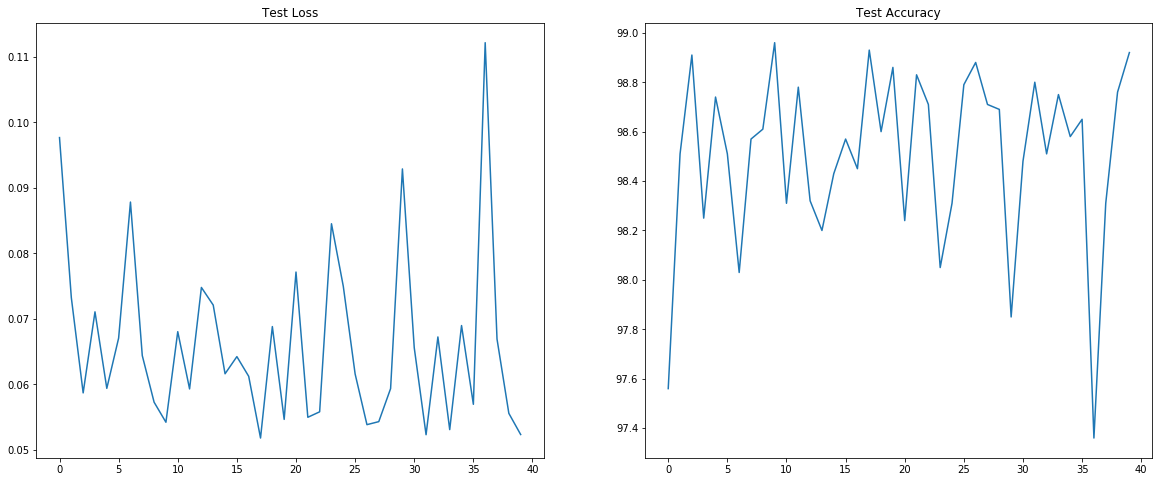

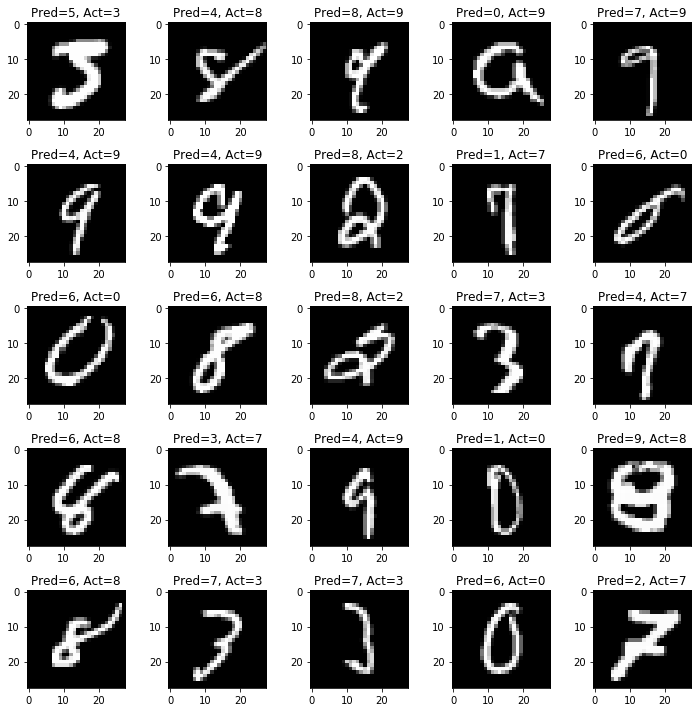

In [21]:
invoke_process_with_L2()

  0%|          | 0/938 [00:00<?, ?it/s]

CUDA Available? True
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Co

Loss=0.045960865914821625 Batch_id=937 Accuracy=92.25: 100%|██████████| 938/938 [00:23<00:00, 40.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9790/10000 (97.90%)

EPOCH: 1


Loss=0.07930431514978409 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:23<00:00, 40.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9810/10000 (98.10%)

EPOCH: 2


Loss=0.2157910168170929 Batch_id=937 Accuracy=97.60: 100%|██████████| 938/938 [00:23<00:00, 40.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.13449795544147491 Batch_id=937 Accuracy=97.85: 100%|██████████| 938/938 [00:24<00:00, 38.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 9818/10000 (98.18%)

EPOCH: 4


Loss=0.04127302020788193 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:23<00:00, 40.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.09843029081821442 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:23<00:00, 40.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9862/10000 (98.62%)

EPOCH: 6


Loss=0.11037883162498474 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:23<00:00, 39.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0860, Accuracy: 9826/10000 (98.26%)

EPOCH: 7


Loss=0.17878594994544983 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:24<00:00, 37.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9864/10000 (98.64%)

EPOCH: 8


Loss=0.08095803111791611 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:23<00:00, 39.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9846/10000 (98.46%)

EPOCH: 9


Loss=0.05127835273742676 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [00:24<00:00, 38.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0654, Accuracy: 9847/10000 (98.47%)

EPOCH: 10


Loss=0.08639886230230331 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:24<00:00, 38.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 9865/10000 (98.65%)

EPOCH: 11


Loss=0.0469164103269577 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:23<00:00, 39.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 9858/10000 (98.58%)

EPOCH: 12


Loss=0.021460983902215958 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:24<00:00, 37.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9856/10000 (98.56%)

EPOCH: 13


Loss=0.07729078084230423 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:24<00:00, 38.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9889/10000 (98.89%)

EPOCH: 14


Loss=0.15039315819740295 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:24<00:00, 37.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9849/10000 (98.49%)

EPOCH: 15


Loss=0.23200324177742004 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:24<00:00, 43.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9844/10000 (98.44%)

EPOCH: 16


Loss=0.05813635513186455 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:24<00:00, 38.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9837/10000 (98.37%)

EPOCH: 17


Loss=0.10589402914047241 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:24<00:00, 37.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9879/10000 (98.79%)

EPOCH: 18


Loss=0.03268091380596161 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:24<00:00, 37.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.1387483775615692 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:24<00:00, 38.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9882/10000 (98.82%)

EPOCH: 20


Loss=0.0772731602191925 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:23<00:00, 39.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9857/10000 (98.57%)

EPOCH: 21


Loss=0.0429343543946743 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:23<00:00, 40.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9881/10000 (98.81%)

EPOCH: 22


Loss=0.1341257095336914 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:23<00:00, 40.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9855/10000 (98.55%)

EPOCH: 23


Loss=0.09255344420671463 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:23<00:00, 47.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9853/10000 (98.53%)

EPOCH: 24


Loss=0.10717970877885818 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9881/10000 (98.81%)

EPOCH: 25


Loss=0.06898719817399979 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:23<00:00, 39.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9883/10000 (98.83%)

EPOCH: 26


Loss=0.09185616672039032 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:24<00:00, 38.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0988, Accuracy: 9766/10000 (97.66%)

EPOCH: 27


Loss=0.04819975420832634 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:24<00:00, 38.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9832/10000 (98.32%)

EPOCH: 28


Loss=0.09664765000343323 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:24<00:00, 38.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9875/10000 (98.75%)

EPOCH: 29


Loss=0.06255953013896942 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:24<00:00, 38.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0587, Accuracy: 9863/10000 (98.63%)

EPOCH: 30


Loss=0.08038157969713211 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:24<00:00, 38.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9838/10000 (98.38%)

EPOCH: 31


Loss=0.06678935140371323 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:24<00:00, 38.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9893/10000 (98.93%)

EPOCH: 32


Loss=0.3334186375141144 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:23<00:00, 39.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9834/10000 (98.34%)

EPOCH: 33


Loss=0.034197188913822174 Batch_id=937 Accuracy=98.07: 100%|██████████| 938/938 [00:23<00:00, 39.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9885/10000 (98.85%)

EPOCH: 34


Loss=0.14913886785507202 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:23<00:00, 39.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0580, Accuracy: 9883/10000 (98.83%)

EPOCH: 35


Loss=0.1233489066362381 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:24<00:00, 38.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0878, Accuracy: 9799/10000 (97.99%)

EPOCH: 36


Loss=0.2046799510717392 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:24<00:00, 45.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0706, Accuracy: 9823/10000 (98.23%)

EPOCH: 37


Loss=0.16038711369037628 Batch_id=937 Accuracy=98.15: 100%|██████████| 938/938 [00:24<00:00, 39.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9809/10000 (98.09%)

EPOCH: 38


Loss=0.2015591710805893 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:23<00:00, 39.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9810/10000 (98.10%)

EPOCH: 39


Loss=0.07780632376670837 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:24<00:00, 38.83it/s]



Test set: Average loss: 0.0581, Accuracy: 9872/10000 (98.72%)



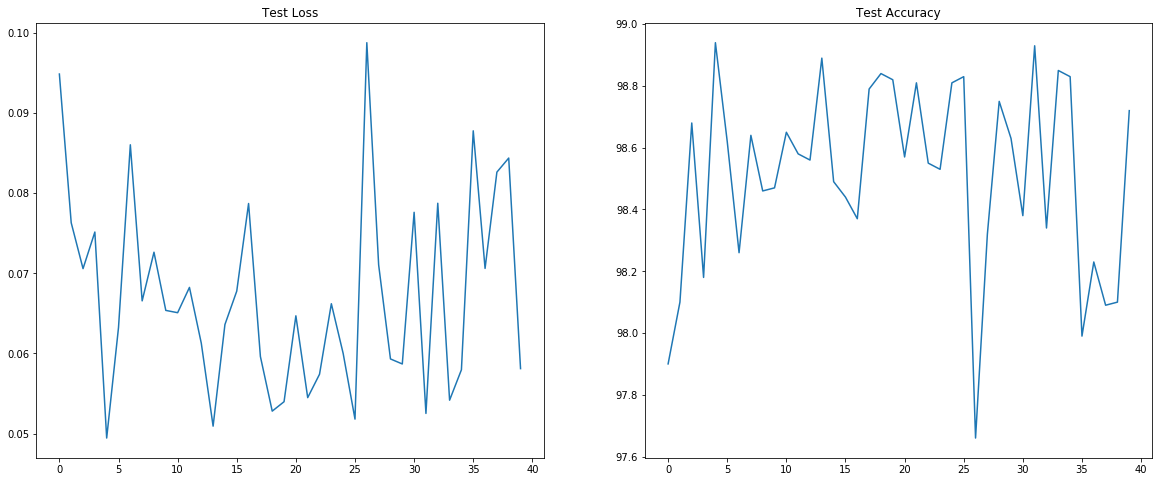

In [22]:
invoke_process_with_L1_and_L2()

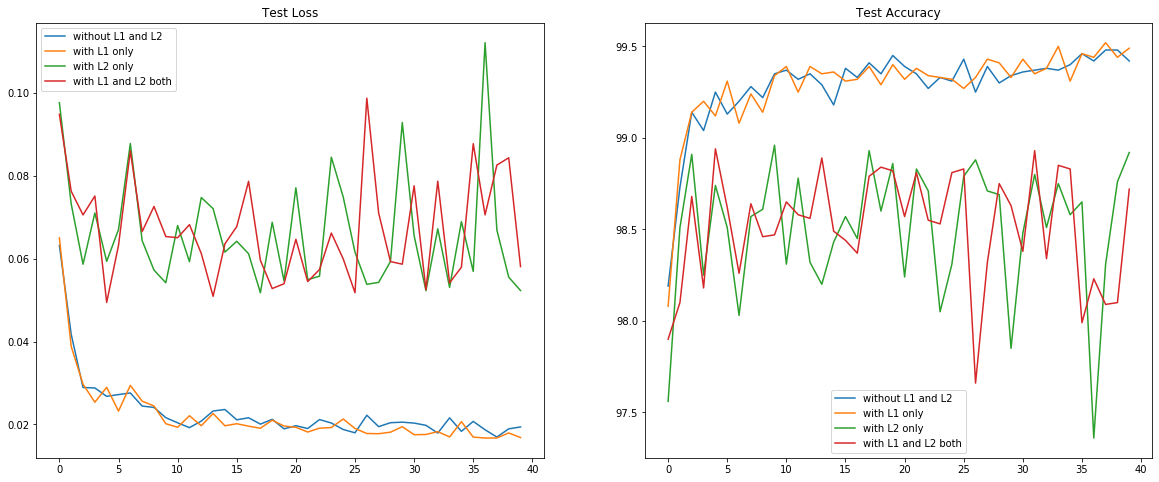

In [23]:
plotall()